In [1]:
!pip install -U transformers datasets seqeval evaluate accelerate bitsandbytes sklearn-crfsuite -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━

## Training without Lora

In [2]:
import json
import torch
import numpy as np
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, DataCollatorWithPadding
from peft import LoraConfig, get_peft_model
from sklearn.model_selection import KFold
from seqeval.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from transformers import DataCollatorForTokenClassification
import evaluate

In [3]:
# Định nghĩa danh sách nhãn
label_list = ["O", "B-Name", "I-Name", "B-Position", "I-Position", "B-Company", "I-Company", "B-Address", "I-Address", "B-Phone", "I-Phone", "B-Email", "I-Email", "B-Department", "I-Department"]
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for i, label in enumerate(label_list)}
seqeval = evaluate.load("seqeval")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
def load_data(json_path):
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    return data

In [5]:
# model_checkpoint = "bert-base-multilingual-cased"
model_checkpoint = "dslim/bert-base-NER"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [6]:
def tokenize_and_align_labels(examples):
    # print(examples)
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        padding="max_length",
        max_length=128,
        is_split_into_words=True
    )

    labels = []
    word_ids = tokenized_inputs.word_ids()
    previous_word_idx = None

    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)  # Token đặc biệt (CLS, SEP, PAD)
        elif word_idx < len(examples["ner_tags"]):  # Đảm bảo không vượt quá độ dài danh sách nhãn
            if word_idx != previous_word_idx:
                labels.append(label2id.get(examples["ner_tags"][word_idx], 0))
            else:
                prev_label = examples["ner_tags"][previous_word_idx]
                if prev_label.startswith("B-"):
                    labels.append(label2id.get("I-" + prev_label[2:], 0))
                else:
                    labels.append(label2id.get(prev_label, 0))
            previous_word_idx = word_idx
        else:
            labels.append(-100)  # Nếu word_idx vượt quá danh sách nhãn, bỏ qua token này

    tokenized_inputs["labels"] = labels
    return tokenized_inputs


    # Gán nhãn đã được căn chỉnh vào dữ liệu tokenized
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [7]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels, zero_division=0)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "eval_f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [8]:
from transformers import TrainerCallback
import csv
import os

class CSVLoggerCallback(TrainerCallback):
    def __init__(self, log_path):
        self.log_path = log_path
        self.initialized = False

    def on_log(self, args, state, control, logs=None, **kwargs):
        if not logs or "eval_loss" not in logs:
            return

        header = ["Epoch", "Validation Loss", "F1", "Precision", "Recall", "Accuracy"]
        row = [
            state.epoch,
            logs.get("eval_loss", ""),
            logs.get("eval_f1", ""),
            logs.get("eval_precision", ""),
            logs.get("eval_recall", ""),
            logs.get("eval_accuracy", ""),
        ]

        file_exists = os.path.isfile(self.log_path)
        with open(self.log_path, mode="a", newline="") as f:
            writer = csv.writer(f)
            if not self.initialized:
                if not file_exists:
                    writer.writerow(header)
                self.initialized = True
            writer.writerow(row)

In [17]:
from peft import LoraConfig, get_peft_model, TaskType, replace_lora_weights_loftq
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer, BitsAndBytesConfig
import torch
from peft import prepare_model_for_kbit_training



def train_fold(train_dataset, val_dataset, fold_id):
    device = torch.device("cuda")

    model = AutoModelForTokenClassification.from_pretrained(
        model_checkpoint,
        num_labels=len(label_list),
        id2label=id2label,
        label2id=label2id,
        ignore_mismatched_sizes=True
    )

    training_args = TrainingArguments(
        output_dir=f"./ner_fold{fold_id}",
        gradient_checkpointing=True,
        gradient_checkpointing_kwargs={'use_reentrant':False}, # suppress warnings
        save_strategy="epoch",
        eval_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=100,
        weight_decay=0.01,
        logging_dir=f"./logs_fold{fold_id}",
        logging_steps=10,
        logging_strategy="epoch",
        report_to="none",
        fp16=True,                                      # Use 16-bit floating point precision to reduce memory usage and speed up training.
        optim="paged_adamw_8bit",                       # Use an 8-bit AdamW optimizer for memory efficiency and faster computation.
        load_best_model_at_end=True,                   # <-- Chỉ lưu mô hình tốt nhất
        metric_for_best_model="accuracy",                    # <-- Dựa theo F1
        greater_is_better=True,                        # <-- F1 càng lớn càng tốt
        save_total_limit=1                             # <-- Chỉ giữ 1 checkpoint tốt nhất
    )
    csv_logger = CSVLoggerCallback(log_path=f"./ner_fold{fold_id}/metrics.csv")

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,  # sửa tên đúng là `tokenizer`, không phải `processing_class`
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks=[csv_logger]
    )


    trainer.train()

In [15]:
def plot_metrics(metrics_list):
    folds = range(1, len(metrics_list) + 1)
    precision = [m["precision"] for m in metrics_list]
    recall = [m["recall"] for m in metrics_list]
    f1 = [m["f1"] for m in metrics_list]

    plt.figure(figsize=(10, 5))
    plt.plot(folds, precision, label="Precision", marker="o")
    plt.plot(folds, recall, label="Recall", marker="s")
    plt.plot(folds, f1, label="F1-score", marker="d")

    plt.xlabel("Fold")
    plt.ylabel("Score")
    plt.title("NER Model Performance across Folds")
    plt.legend()
    plt.grid()
    plt.show()


In [16]:
def cross_validate(json_path, k=5):
    data = load_data(json_path)
    dataset = Dataset.from_list([tokenize_and_align_labels(sample) for sample in data])

    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    all_metrics = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        train_dataset = dataset.select(train_idx)
        val_dataset = dataset.select(val_idx)

        print(f"Starting Fold {fold}...")
        train_fold(train_dataset, val_dataset, fold)

In [12]:
from transformers import AutoConfig
config = AutoConfig.from_pretrained(model_checkpoint)
print(config.num_labels)

9


In [18]:
cross_validate("data_ner.json", k=10)

Starting Fold 0...


Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at dslim/bert-base-NER and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([9]) in the checkpoint and torch.Size([15]) in the model instantiated
- classifier.weight: found shape torch.Size([9, 768])

Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,2.126200,1.486093,0.123967,0.107914,0.145631,0.560044
2,1.358800,1.051772,0.192308,0.190476,0.194175,0.679039
3,0.956900,0.807801,0.240838,0.261364,0.223301,0.758734
4,0.717300,0.669069,0.347418,0.336364,0.359223,0.791485
5,0.541700,0.635817,0.445545,0.454545,0.436893,0.810044
6,0.426100,0.569949,0.495050,0.505051,0.485437,0.832969
7,0.323700,0.513294,0.594340,0.577982,0.611650,0.843886
8,0.256500,0.488539,0.618357,0.615385,0.621359,0.863537
9,0.207400,0.514734,0.663507,0.648148,0.679612,0.861354
10,0.169300,0.519075,0.603604,0.563025,0.650485,0.854803


Starting Fold 1...


Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at dslim/bert-base-NER and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([9]) in the checkpoint and torch.Size([15]) in the model instantiated
- classifier.weight: found shape torch.Size([9, 768])

Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,2.167600,1.539844,0.060837,0.048193,0.082474,0.512118
2,1.297900,1.122762,0.082569,0.074380,0.092784,0.628030
3,0.945200,0.917329,0.121827,0.120000,0.123711,0.682824
4,0.720300,0.769140,0.252632,0.258065,0.247423,0.741834
5,0.543800,0.726250,0.257143,0.238938,0.278351,0.759747
6,0.420400,0.712575,0.362745,0.345794,0.381443,0.751317
7,0.322500,0.717586,0.437209,0.398305,0.484536,0.777661
8,0.275700,0.677606,0.519608,0.495327,0.546392,0.786091
9,0.222700,0.720539,0.473934,0.438596,0.515464,0.788198
10,0.172100,0.650841,0.488263,0.448276,0.536082,0.793467


Starting Fold 2...


Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at dslim/bert-base-NER and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([9]) in the checkpoint and torch.Size([15]) in the model instantiated
- classifier.weight: found shape torch.Size([9, 768])

Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,2.160700,1.551575,0.114833,0.096000,0.142857,0.575388
2,1.313000,1.058702,0.135593,0.129032,0.142857,0.705100
3,0.938200,0.891358,0.252874,0.244444,0.261905,0.711752
4,0.727300,0.720717,0.383721,0.375000,0.392857,0.774945
5,0.566600,0.657175,0.448485,0.456790,0.440476,0.798226
6,0.453100,0.626063,0.545455,0.521739,0.571429,0.820399
7,0.345100,0.618842,0.629834,0.587629,0.678571,0.828160
8,0.282500,0.630499,0.699454,0.646465,0.761905,0.832594
9,0.235200,0.529063,0.659459,0.603960,0.726190,0.841463
10,0.192500,0.621515,0.587065,0.504274,0.702381,0.831486


Starting Fold 3...


Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at dslim/bert-base-NER and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([9]) in the checkpoint and torch.Size([15]) in the model instantiated
- classifier.weight: found shape torch.Size([9, 768])

Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,2.173100,1.561968,0.068441,0.053571,0.094737,0.531574
2,1.287000,1.118415,0.076555,0.070175,0.084211,0.655985
3,0.908600,0.939396,0.130653,0.125000,0.136842,0.716305
4,0.689000,0.855459,0.168224,0.151261,0.189474,0.740811
5,0.541600,0.804159,0.213198,0.205882,0.221053,0.761546
6,0.433400,0.739107,0.334975,0.314815,0.357895,0.787936
7,0.334400,0.684168,0.295238,0.269565,0.326316,0.793591
8,0.266600,0.676189,0.347418,0.313559,0.389474,0.792648
9,0.228900,0.612493,0.312500,0.271318,0.368421,0.816211
10,0.190200,0.593383,0.444444,0.427184,0.463158,0.830349


Starting Fold 4...


Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at dslim/bert-base-NER and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([9]) in the checkpoint and torch.Size([15]) in the model instantiated
- classifier.weight: found shape torch.Size([9, 768])

Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,2.191100,1.409991,0.119658,0.100719,0.147368,0.605450
2,1.342600,0.960367,0.172973,0.177778,0.168421,0.704976
3,0.975900,0.809607,0.222222,0.223404,0.221053,0.754739
4,0.738600,0.650925,0.295918,0.287129,0.305263,0.795024
5,0.592900,0.545126,0.437158,0.454545,0.421053,0.831754
6,0.465000,0.462524,0.456853,0.441176,0.473684,0.854265
7,0.363500,0.426221,0.486772,0.489362,0.484211,0.866114
8,0.289700,0.416908,0.585859,0.563107,0.610526,0.874408
9,0.240300,0.422939,0.580000,0.552381,0.610526,0.872038
10,0.200400,0.390658,0.620690,0.583333,0.663158,0.885071


Starting Fold 5...


Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at dslim/bert-base-NER and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([9]) in the checkpoint and torch.Size([15]) in the model instantiated
- classifier.weight: found shape torch.Size([9, 768])

Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,2.183600,1.545041,0.116667,0.097902,0.144330,0.532438
2,1.341300,1.068879,0.159574,0.164835,0.154639,0.702461
3,0.970900,0.823216,0.248705,0.250000,0.247423,0.740492
4,0.725400,0.664237,0.300518,0.302083,0.298969,0.786353
5,0.561000,0.596697,0.381910,0.372549,0.391753,0.805369
6,0.440700,0.505001,0.470588,0.448598,0.494845,0.835570
7,0.339500,0.543150,0.514286,0.477876,0.556701,0.809843
8,0.268900,0.465838,0.509434,0.469565,0.556701,0.859060
9,0.230200,0.422855,0.504673,0.461538,0.556701,0.845638
10,0.182000,0.455402,0.542714,0.529412,0.556701,0.856823


Starting Fold 6...


Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at dslim/bert-base-NER and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([9]) in the checkpoint and torch.Size([15]) in the model instantiated
- classifier.weight: found shape torch.Size([9, 768])

Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,2.161900,1.507684,0.084291,0.065476,0.118280,0.549370
2,1.305500,1.097180,0.186047,0.163934,0.215054,0.650210
3,0.940300,0.900752,0.224390,0.205357,0.247312,0.684874
4,0.727000,0.758992,0.253807,0.240385,0.268817,0.744748
5,0.557700,0.648589,0.348718,0.333333,0.365591,0.800420
6,0.432400,0.634760,0.398010,0.370370,0.430108,0.804622
7,0.341900,0.627717,0.450704,0.400000,0.516129,0.817227
8,0.264400,0.503924,0.500000,0.467290,0.537634,0.849790
9,0.224200,0.567369,0.504762,0.452991,0.569892,0.851891
10,0.177100,0.499136,0.526829,0.482143,0.580645,0.873950


Starting Fold 7...


Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at dslim/bert-base-NER and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([9]) in the checkpoint and torch.Size([15]) in the model instantiated
- classifier.weight: found shape torch.Size([9, 768])

Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,2.176000,1.398870,0.079602,0.067227,0.097561,0.634518
2,1.314200,0.950997,0.112821,0.097345,0.134146,0.729695
3,0.950000,0.704186,0.202247,0.187500,0.219512,0.794416
4,0.716500,0.593401,0.296296,0.300000,0.292683,0.832487
5,0.558500,0.546413,0.372671,0.379747,0.365854,0.846447
6,0.426900,0.499940,0.390244,0.390244,0.390244,0.865482
7,0.329000,0.497922,0.451220,0.451220,0.451220,0.860406
8,0.250000,0.492273,0.456140,0.438202,0.475610,0.866751
9,0.213300,0.462593,0.469945,0.425743,0.524390,0.859137
10,0.168400,0.463723,0.497238,0.454545,0.548780,0.876904


Starting Fold 8...


Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at dslim/bert-base-NER and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([9]) in the checkpoint and torch.Size([15]) in the model instantiated
- classifier.weight: found shape torch.Size([9, 768])

Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,2.170200,1.681679,0.103896,0.081633,0.142857,0.452830
2,1.297500,1.273892,0.105769,0.088710,0.130952,0.575968
3,0.902700,1.056214,0.187192,0.159664,0.226190,0.671301
4,0.685900,0.948390,0.235294,0.213592,0.261905,0.707051
5,0.522700,0.886911,0.318681,0.295918,0.345238,0.727905
6,0.405000,0.863051,0.329787,0.298077,0.369048,0.754717
7,0.313500,0.794488,0.286996,0.230216,0.380952,0.759682
8,0.256800,0.833731,0.368159,0.316239,0.440476,0.767627
9,0.208000,0.798667,0.326733,0.279661,0.392857,0.799404
10,0.173700,0.837957,0.398010,0.341880,0.476190,0.782522


Starting Fold 9...


Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at dslim/bert-base-NER and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([9]) in the checkpoint and torch.Size([15]) in the model instantiated
- classifier.weight: found shape torch.Size([9, 768])

Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,2.166600,1.506536,0.082988,0.067114,0.108696,0.568562
2,1.315800,1.052557,0.139535,0.121951,0.163043,0.683389
3,0.963500,0.902232,0.182741,0.171429,0.195652,0.702341
4,0.735700,0.725968,0.241206,0.224299,0.260870,0.763657
5,0.572400,0.619361,0.343434,0.320755,0.369565,0.778149
6,0.456900,0.555874,0.431579,0.418367,0.445652,0.810479
7,0.349400,0.554885,0.492754,0.443478,0.554348,0.817168
8,0.288200,0.506574,0.494845,0.470588,0.521739,0.824972
9,0.238500,0.508108,0.547368,0.530612,0.565217,0.841695
10,0.193300,0.562637,0.567010,0.539216,0.597826,0.846154


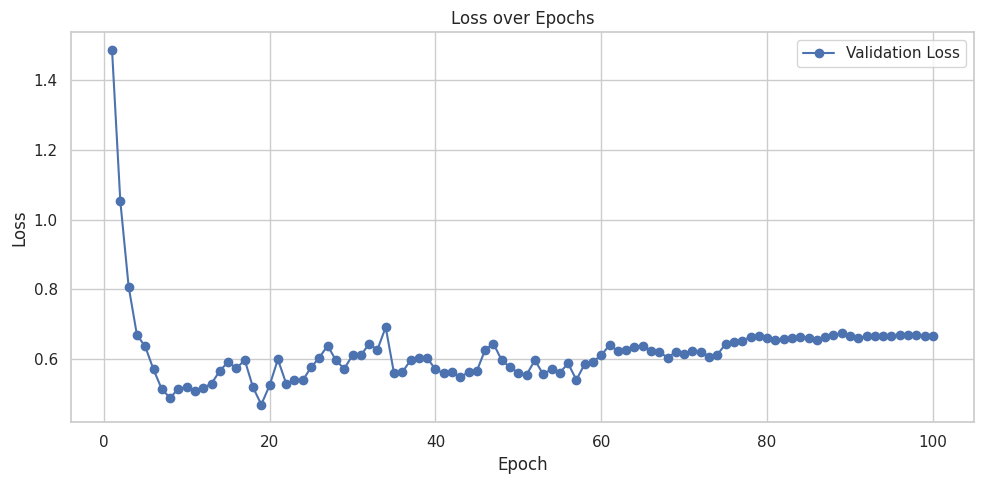

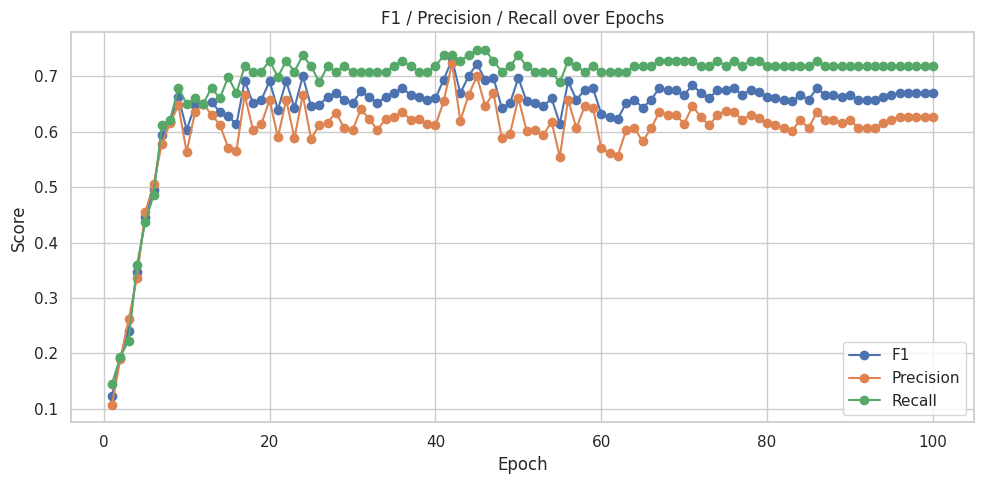

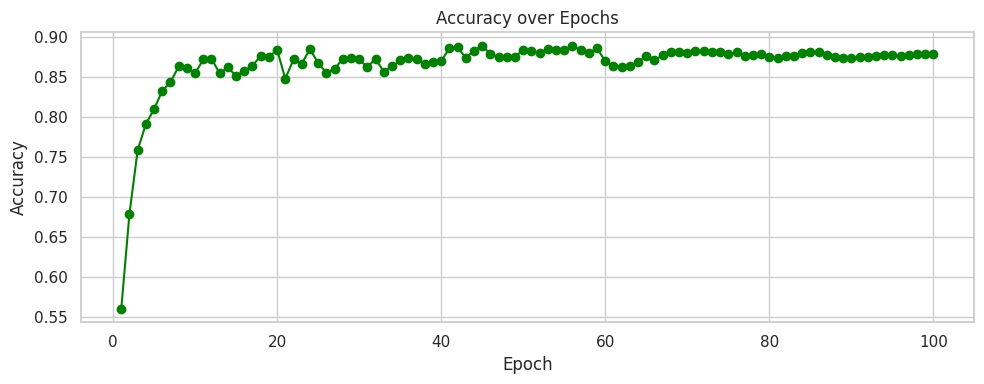

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Đọc dữ liệu
num_folds = 10  # hoặc bao nhiêu fold bạn có
base_path = "./ner_fold{}"  # path chứa các metrics.csv

# Đọc và gộp dữ liệu
all_folds = []
for i in range(num_folds):
    csv_path = os.path.join(base_path.format(i), "metrics.csv")
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        df["Fold"] = f"Fold {i}"
df = pd.read_csv("./ner_fold0/metrics.csv")  # thay path nếu cần

# Thiết lập style
sns.set(style="whitegrid")

# Vẽ Training Loss & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(df["Epoch"], df["Validation Loss"], label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.tight_layout()
plt.show()

# Vẽ F1, Precision, Recall
plt.figure(figsize=(10, 5))
plt.plot(df["Epoch"], df["F1"], label="F1", marker='o')
plt.plot(df["Epoch"], df["Precision"], label="Precision", marker='o')
plt.plot(df["Epoch"], df["Recall"], label="Recall", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("F1 / Precision / Recall over Epochs")
plt.legend()
plt.tight_layout()
plt.show()

# Vẽ Accuracy
plt.figure(figsize=(10, 4))
plt.plot(df["Epoch"], df["Accuracy"], label="Accuracy", marker='o', color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.tight_layout()
plt.show()


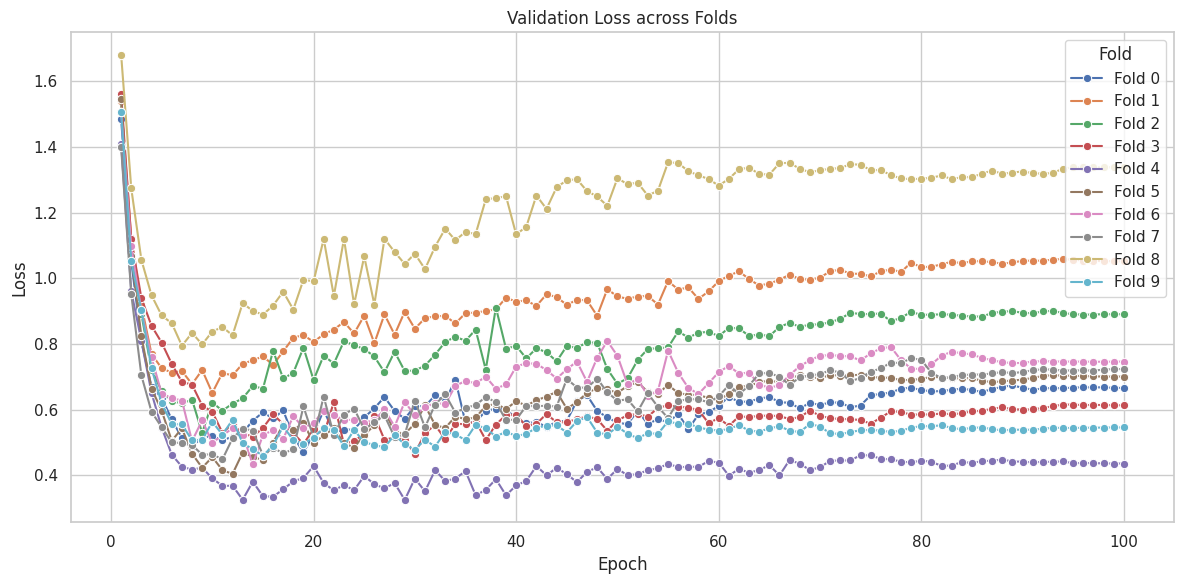

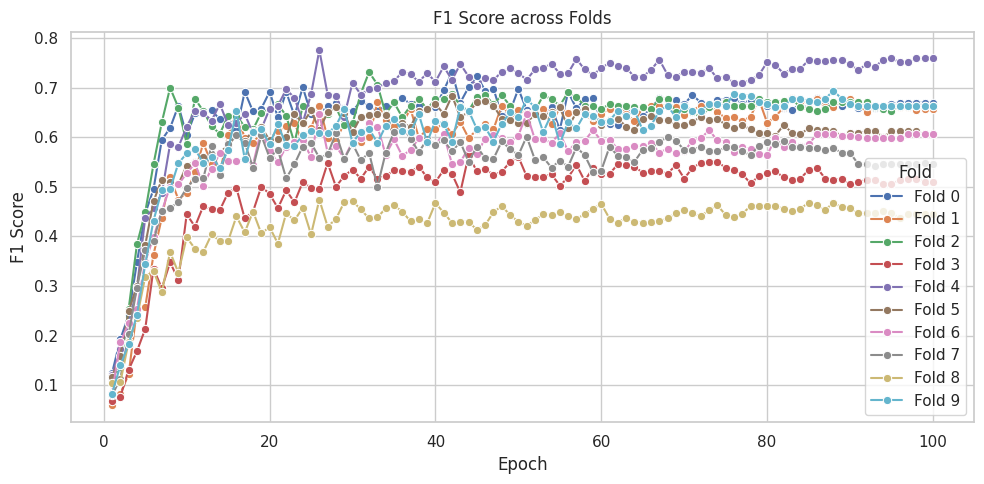

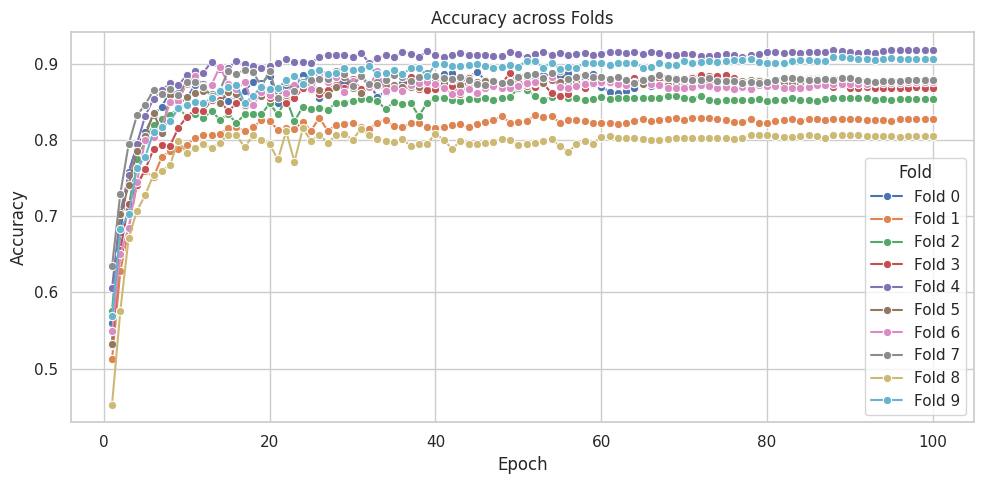

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Cấu hình
num_folds = 10  # hoặc bao nhiêu fold bạn có
base_path = "./ner_fold{}"  # path chứa các metrics.csv

# Đọc và gộp dữ liệu
all_folds = []
for i in range(num_folds):
    csv_path = os.path.join(base_path.format(i), "metrics.csv")
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        df["Fold"] = f"Fold {i}"
        all_folds.append(df)

df_all = pd.concat(all_folds, ignore_index=True)

sns.set(style="whitegrid")

# 1. Training vs Validation Loss (theo fold)
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_all, x="Epoch", y="Validation Loss", hue="Fold", marker='o', linestyle="-")
plt.title("Validation Loss across Folds")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(title="Fold")
plt.tight_layout()
plt.show()

# 2. F1 score theo từng fold
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_all, x="Epoch", y="F1", hue="Fold", marker='o')
plt.title("F1 Score across Folds")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.show()

# 3. Accuracy theo từng fold
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_all, x="Epoch", y="Accuracy", hue="Fold", marker='o')
plt.title("Accuracy across Folds")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()


In [21]:
import pandas as pd
import os

num_folds = 10   # Số lượng fold
base_path = "./ner_fold{}"  # Đường dẫn chứa metrics.csv

last_epoch_metrics = []

for i in range(num_folds):
    csv_path = os.path.join(base_path.format(i), "metrics.csv")
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        last_row = df.iloc[-1]  # Dòng cuối cùng (epoch cuối)
        last_row["Fold"] = i
        last_epoch_metrics.append(last_row)

df_last_epochs = pd.DataFrame(last_epoch_metrics)

In [22]:
metrics_to_avg = [ "Validation Loss", "F1", "Precision", "Recall", "Accuracy"]
avg_metrics = df_last_epochs[metrics_to_avg].mean()

print("📊 Trung bình các chỉ số:")
print(avg_metrics)


📊 Trung bình các chỉ số:
Validation Loss    0.771263
F1                 0.612319
Precision          0.556811
Recall             0.682717
Accuracy           0.869230
dtype: float64


In [23]:
# prompt: gen code download folder to local format zip file

import shutil
import os

def download_folder_as_zip(folder_path, zip_filename):
    """
    Downloads a folder as a zip file to the local machine.

    Args:
        folder_path: The path to the folder to be zipped.
        zip_filename: The name of the zip file to be created.
    """
    try:
        shutil.make_archive(zip_filename, 'zip', folder_path)
        print(f"Folder '{folder_path}' successfully zipped to '{zip_filename}.zip'")
    except FileNotFoundError:
        print(f"Error: Folder '{folder_path}' not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage:
download_folder_as_zip("./ner_fold4", "ner_fold4_data")

from google.colab import files
files.download('ner_fold4_data.zip')


Folder './ner_fold4' successfully zipped to 'ner_fold4_data.zip'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Training with Lora

In [ ]:
import json
import torch
import numpy as np
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, DataCollatorWithPadding
from peft import LoraConfig, get_peft_model
from sklearn.model_selection import KFold
from seqeval.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from transformers import DataCollatorForTokenClassification
import evaluate

In [ ]:
# Định nghĩa danh sách nhãn
label_list = ["O", "B-Name", "I-Name", "B-Position", "I-Position", "B-Company", "I-Company", "B-Address", "I-Address", "B-Phone", "I-Phone", "B-Email", "I-Email", "B-Department", "I-Department"]
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for i, label in enumerate(label_list)}
seqeval = evaluate.load("seqeval")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
def load_data(json_path):
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    return data

In [ ]:
# model_checkpoint = "bert-base-multilingual-cased"
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def gpu_collate_fn(batch):
    device = torch.device(f"cuda:{torch.cuda.current_device()}" if torch.cuda.is_available() else "cpu")
    batch = DataCollatorForTokenClassification(tokenizer=tokenizer)(batch)  # Gọi collator gốc
    batch = {k: v.to(device) for k, v in batch.items()}  # Chuyển về GPU
    return batch

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
def tokenize_and_align_labels(examples):
    # print(examples)
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        padding="max_length",
        max_length=128,
        is_split_into_words=True
    )

    labels = []
    word_ids = tokenized_inputs.word_ids()
    previous_word_idx = None

    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)  # Token đặc biệt (CLS, SEP, PAD)
        elif word_idx < len(examples["ner_tags"]):  # Đảm bảo không vượt quá độ dài danh sách nhãn
            if word_idx != previous_word_idx:
                labels.append(label2id.get(examples["ner_tags"][word_idx], 0))
            else:
                prev_label = examples["ner_tags"][previous_word_idx]
                if prev_label.startswith("B-"):
                    labels.append(label2id.get("I-" + prev_label[2:], 0))
                else:
                    labels.append(label2id.get(prev_label, 0))
            previous_word_idx = word_idx
        else:
            labels.append(-100)  # Nếu word_idx vượt quá danh sách nhãn, bỏ qua token này

    tokenized_inputs["labels"] = labels
    return tokenized_inputs


    # Gán nhãn đã được căn chỉnh vào dữ liệu tokenized
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [ ]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "eval_f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [ ]:
import csv
import os
from transformers import TrainerCallback

class CSVLoggerCallback(TrainerCallback):
    def __init__(self, log_path):
        self.log_path = log_path
        self.headers_written = False

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is None:
            return

        logs_to_save = {
            "epoch": logs.get("epoch"),
            "train_loss": logs.get("loss"),
            "eval_loss": logs.get("eval_loss"),
            "f1": logs.get("f1"),
            "precision": logs.get("precision"),
            "recall": logs.get("recall"),
            "accuracy": logs.get("accuracy")
        }

        # Ghi vào file CSV
        write_headers = not os.path.exists(self.log_path)
        with open(self.log_path, mode='a', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=logs_to_save.keys())
            if write_headers:
                writer.writeheader()
            writer.writerow(logs_to_save)

In [ ]:
from peft import LoraConfig, get_peft_model, TaskType, replace_lora_weights_loftq
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer, BitsAndBytesConfig
import torch
from peft import prepare_model_for_kbit_training



def train_fold(train_dataset, val_dataset, fold_id):
    device = torch.device("cuda")
    config = BitsAndBytesConfig(
        load_in_4bit=True, # quantize the model to 4-bits when you load it
        bnb_4bit_quant_type="nf4", # use a special 4-bit data type for weights initialized from a normal distribution
        bnb_4bit_use_double_quant=True, # nested quantization scheme to quantize the already quantized weights
        bnb_4bit_compute_dtype=torch.bfloat16, # use bfloat16 for faster computation
        llm_int8_skip_modules=["classifier", "pre_classifier"]
    )

    model = AutoModelForTokenClassification.from_pretrained(
        model_checkpoint,
        num_labels=len(label_list),
        id2label=id2label,
        label2id=label2id,
        quantization_config=config
    )

    model = prepare_model_for_kbit_training(model)

    # Apply LoRA
    config = LoraConfig(
        r=256, # we use a higher rank here as the task is more complex so we want less information loss
        lora_alpha=64,
        target_modules=["q_lin", "k_lin", "v_lin", "out_lin"],
        task_type=TaskType.TOKEN_CLS)

    peft_model = get_peft_model(model, config)
    print_trainable_parameters(peft_model)

    training_args = TrainingArguments(
        output_dir=f"./ner_lora_fold{fold_id}",
        gradient_checkpointing=True,
        gradient_checkpointing_kwargs={'use_reentrant':False}, # suppress warnings
        save_strategy="epoch",
        eval_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=1000,
        weight_decay=0.01,
        logging_dir=f"./logs_fold{fold_id}",
        logging_steps=100,
        logging_strategy="epoch",
        report_to="none",
        fp16=True,                                      # Use 16-bit floating point precision to reduce memory usage and speed up training.
        optim="paged_adamw_8bit",                       # Use an 8-bit AdamW optimizer for memory efficiency and faster computation.
    )
    csv_logger = CSVLoggerCallback(log_path=f"./ner_lora_fold{fold_id}/metrics.csv")

    trainer = Trainer(
        model=peft_model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        processing_class=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks=[csv_logger],
    )
    print(trainer.compute_metrics)
    print(trainer.compute_metrics.__code__)  # Kiểm tra mã nguồn hàm đang được Trainer sử dụng

    trainer.train()

In [ ]:
def plot_metrics(metrics_list):
    folds = range(1, len(metrics_list) + 1)
    precision = [m["precision"] for m in metrics_list]
    recall = [m["recall"] for m in metrics_list]
    f1 = [m["f1"] for m in metrics_list]

    plt.figure(figsize=(10, 5))
    plt.plot(folds, precision, label="Precision", marker="o")
    plt.plot(folds, recall, label="Recall", marker="s")
    plt.plot(folds, f1, label="F1-score", marker="d")

    plt.xlabel("Fold")
    plt.ylabel("Score")
    plt.title("NER Model Performance across Folds")
    plt.legend()
    plt.grid()
    plt.show()


In [ ]:
def cross_validate(json_path, k=5):
    data = load_data(json_path)
    dataset = Dataset.from_list([tokenize_and_align_labels(sample) for sample in data])

    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    all_metrics = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        train_dataset = dataset.select(train_idx)
        val_dataset = dataset.select(val_idx)

        print(f"Starting Fold {fold}...")
        train_fold(train_dataset, val_dataset, fold)

In [ ]:
cross_validate("data_ner.json", k=10)

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Starting Fold 0...


Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 9448719 || all params: 54589470 || trainable%: 17.30868425723862
<function compute_metrics at 0x7f0d4640a980>
<code object compute_metrics at 0x7f0d46581890, file "<ipython-input-9-632ddd49a27b>", line 1>


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,2.733300,2.709847,0.005908,0.003425,0.021505,0.078353
2,2.659800,2.639560,0.008529,0.005319,0.021505,0.134130
3,2.579300,2.558750,0.006250,0.004405,0.010753,0.164675
4,2.489400,2.460812,0.000000,0.000000,0.000000,0.196547
5,2.361500,2.350269,0.008734,0.007353,0.010753,0.200531
6,2.259600,2.264044,0.008097,0.006494,0.010753,0.225764
7,2.189500,2.214995,0.008439,0.006944,0.010753,0.262948
8,2.156300,2.176696,0.025424,0.020979,0.032258,0.281541
9,2.117000,2.134576,0.035714,0.030534,0.043011,0.310757
10,2.048000,2.093194,0.009259,0.008130,0.010753,0.321381


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-sco

Starting Fold 1...


Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 9448719 || all params: 54589470 || trainable%: 17.30868425723862
<function compute_metrics at 0x7f0d4640a980>
<code object compute_metrics at 0x7f0d46581890, file "<ipython-input-9-632ddd49a27b>", line 1>


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,2.711000,2.676455,0.000000,0.000000,0.000000,0.084325
2,2.637600,2.597471,0.000000,0.000000,0.000000,0.147817
3,2.560800,2.499146,0.003175,0.001869,0.010526,0.245040
4,2.445400,2.379683,0.010417,0.006920,0.021053,0.340278
5,2.337300,2.244433,0.007547,0.005882,0.010526,0.362103
6,2.213600,2.152220,0.008264,0.006803,0.010526,0.377976
7,2.135500,2.101637,0.025000,0.020690,0.031579,0.383929
8,2.095800,2.052786,0.044843,0.039062,0.052632,0.393849
9,2.032600,2.004626,0.044053,0.037879,0.052632,0.393849
10,1.985100,1.958196,0.056075,0.050420,0.063158,0.391865


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-sco

Starting Fold 2...


Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 9448719 || all params: 54589470 || trainable%: 17.30868425723862
<function compute_metrics at 0x7f0d4640a980>
<code object compute_metrics at 0x7f0d46581890, file "<ipython-input-9-632ddd49a27b>", line 1>


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,2.711500,2.667831,0.002538,0.001466,0.009434,0.105967
2,2.637800,2.596129,0.000000,0.000000,0.000000,0.171811
3,2.551600,2.507021,0.000000,0.000000,0.000000,0.270576
4,2.443400,2.401314,0.000000,0.000000,0.000000,0.317901
5,2.306900,2.290724,0.000000,0.000000,0.000000,0.325103
6,2.204100,2.214774,0.013699,0.010753,0.018868,0.327160
7,2.127000,2.165085,0.014706,0.012048,0.018868,0.343621
8,2.095300,2.116862,0.024194,0.021127,0.028302,0.359053
9,2.027800,2.072695,0.033195,0.029630,0.037736,0.359053
10,1.974300,2.032064,0.035242,0.033058,0.037736,0.362140


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-sco

Starting Fold 3...


Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 9448719 || all params: 54589470 || trainable%: 17.30868425723862
<function compute_metrics at 0x7f0d4640a980>
<code object compute_metrics at 0x7f0d46581890, file "<ipython-input-9-632ddd49a27b>", line 1>


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,2.713900,2.658391,0.002692,0.001543,0.010526,0.106316
2,2.638600,2.590270,0.003053,0.001786,0.010526,0.189474
3,2.554500,2.511934,0.003503,0.002101,0.010526,0.251579
4,2.449900,2.415997,0.014963,0.009804,0.031579,0.265263
5,2.317100,2.313293,0.006349,0.004545,0.010526,0.249474
6,2.222100,2.231175,0.006849,0.005076,0.010526,0.253684
7,2.145100,2.162973,0.013158,0.009569,0.021053,0.288421
8,2.097700,2.099494,0.022556,0.017544,0.031579,0.317895
9,2.047300,2.048434,0.042918,0.036232,0.052632,0.321053
10,1.981300,2.008129,0.045045,0.039370,0.052632,0.321053


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-sco

Starting Fold 4...


Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 9448719 || all params: 54589470 || trainable%: 17.30868425723862
<function compute_metrics at 0x7f0d4640a980>
<code object compute_metrics at 0x7f0d46581890, file "<ipython-input-9-632ddd49a27b>", line 1>


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,2.713800,2.676174,0.000000,0.000000,0.000000,0.102715
2,2.641800,2.593340,0.000000,0.000000,0.000000,0.168831
3,2.558500,2.490699,0.000000,0.000000,0.000000,0.288076
4,2.458400,2.358731,0.005764,0.003937,0.010753,0.368359
5,2.331900,2.207772,0.014337,0.010753,0.021505,0.380165
6,2.217400,2.090079,0.015267,0.011834,0.021505,0.386068
7,2.154500,2.029893,0.040323,0.032258,0.053763,0.410862
8,2.104600,1.983358,0.041322,0.033557,0.053763,0.414404
9,2.054200,1.938160,0.062222,0.053030,0.075269,0.413223
10,1.995200,1.887630,0.035242,0.029851,0.043011,0.423849


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-sco

Starting Fold 5...


Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 9448719 || all params: 54589470 || trainable%: 17.30868425723862
<function compute_metrics at 0x7f0d4640a980>
<code object compute_metrics at 0x7f0d46581890, file "<ipython-input-9-632ddd49a27b>", line 1>


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,2.712600,2.666192,0.000000,0.000000,0.000000,0.080574
2,2.637800,2.588784,0.000000,0.000000,0.000000,0.171082
3,2.557900,2.493002,0.000000,0.000000,0.000000,0.283664
4,2.444700,2.377698,0.006329,0.004608,0.010101,0.316777
5,2.322000,2.258971,0.008333,0.007092,0.010101,0.305740
6,2.210600,2.189080,0.000000,0.000000,0.000000,0.301325
7,2.147800,2.138994,0.008889,0.007937,0.010101,0.322296
8,2.106200,2.078191,0.021164,0.022222,0.020202,0.352097
9,2.045600,2.023373,0.021858,0.023810,0.020202,0.354305
10,1.992400,1.973344,0.021622,0.023256,0.020202,0.356512


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-sco

Starting Fold 6...


Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 9448719 || all params: 54589470 || trainable%: 17.30868425723862
<function compute_metrics at 0x7f0d4640a980>
<code object compute_metrics at 0x7f0d46581890, file "<ipython-input-9-632ddd49a27b>", line 1>


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,2.707300,2.674205,0.002667,0.001536,0.010101,0.085540
2,2.641000,2.592444,0.002837,0.001650,0.010101,0.156823
3,2.559000,2.493944,0.003436,0.002070,0.010101,0.284114
4,2.452500,2.372563,0.019293,0.014151,0.030303,0.336049
5,2.333000,2.243028,0.000000,0.000000,0.000000,0.334012
6,2.213500,2.162720,0.008929,0.008000,0.010101,0.331976
7,2.143600,2.117675,0.009009,0.008130,0.010101,0.370672
8,2.100500,2.066164,0.074419,0.068966,0.080808,0.380855
9,2.040400,2.019878,0.086538,0.082569,0.090909,0.383910
10,1.987200,1.978257,0.092308,0.093750,0.090909,0.393075


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-sco

Starting Fold 7...


`low_cpu_mem_usage` was None, now default to True since model is quantized.
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 9448719 || all params: 54589470 || trainable%: 17.30868425723862
<function compute_metrics at 0x7f0d4640a980>
<code object compute_metrics at 0x7f0d46581890, file "<ipython-input-9-632ddd49a27b>", line 1>


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,2.710300,2.674309,0.000000,0.000000,0.000000,0.089239
2,2.643900,2.603241,0.000000,0.000000,0.000000,0.178478
3,2.554800,2.519305,0.000000,0.000000,0.000000,0.278215
4,2.448700,2.417858,0.006349,0.004444,0.011111,0.301837
5,2.318200,2.307200,0.015748,0.012195,0.022222,0.295276
6,2.211800,2.222836,0.017316,0.014184,0.022222,0.295276
7,2.145200,2.159306,0.044248,0.036765,0.055556,0.339895
8,2.098300,2.104155,0.037037,0.031746,0.044444,0.343832
9,2.044000,2.056102,0.057692,0.050847,0.066667,0.347769
10,1.996600,2.010192,0.060914,0.056075,0.066667,0.355643


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-sco

Starting Fold 8...


Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 9448719 || all params: 54589470 || trainable%: 17.30868425723862
<function compute_metrics at 0x7f0d4640a980>
<code object compute_metrics at 0x7f0d46581890, file "<ipython-input-9-632ddd49a27b>", line 1>


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,2.707400,2.683757,0.000000,0.000000,0.000000,0.101215
2,2.638800,2.605301,0.000000,0.000000,0.000000,0.158907
3,2.556300,2.509750,0.000000,0.000000,0.000000,0.243927
4,2.447100,2.389294,0.000000,0.000000,0.000000,0.275304
5,2.326700,2.250458,0.000000,0.000000,0.000000,0.287449
6,2.215700,2.147587,0.000000,0.000000,0.000000,0.296559
7,2.154200,2.081311,0.016393,0.012500,0.023810,0.310729
8,2.103500,2.038867,0.017544,0.013889,0.023810,0.319838
9,2.048500,1.997727,0.027397,0.022222,0.035714,0.320850
10,1.992000,1.960828,0.028302,0.023438,0.035714,0.328947


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-sco

Starting Fold 9...


Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 9448719 || all params: 54589470 || trainable%: 17.30868425723862
<function compute_metrics at 0x7f0d4640a980>
<code object compute_metrics at 0x7f0d46581890, file "<ipython-input-9-632ddd49a27b>", line 1>


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,2.708900,2.671281,0.002574,0.001486,0.009615,0.078895
2,2.643500,2.591043,0.000000,0.000000,0.000000,0.176529
3,2.557000,2.490987,0.003289,0.001984,0.009615,0.294872
4,2.449900,2.364097,0.004751,0.003155,0.009615,0.376726
5,2.326400,2.221141,0.005495,0.003846,0.009615,0.385602
6,2.208100,2.123902,0.012121,0.008850,0.019231,0.387574
7,2.151200,2.071292,0.013514,0.010417,0.019231,0.410256
8,2.103400,2.019778,0.030769,0.025641,0.038462,0.418146
9,2.062500,1.967829,0.030534,0.025316,0.038462,0.422091
10,2.001400,1.917921,0.048193,0.041379,0.057692,0.424063


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-sco

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_metrics(log_path, fold_id):
    df = pd.read_csv(log_path)
    metrics = ["train_loss", "eval_loss", "f1", "precision", "recall", "accuracy"]
    plt.figure(figsize=(14, 8))

    for i, metric in enumerate(metrics):
        plt.subplot(2, 3, i + 1)
        sns.lineplot(x=df["epoch"], y=df[metric])
        plt.title(metric)
        plt.xlabel("Epoch")
        plt.ylabel(metric)

    plt.suptitle(f"Metrics per Epoch - Fold {fold_id}", fontsize=16)
    plt.tight_layout()
    plt.savefig(f"./ner_lora_fold{fold_id}/metrics_plot.png")
    plt.close()

In [ ]:
# Gọi hàm vẽ
for i in range(10):
    fold_id = i
    plot_metrics(f"./ner_lora_fold{fold_id}/metrics.csv", fold_id)

## Inference

In [ ]:
!pip install easyocr

In [ ]:
import easyocr
reader = easyocr.Reader(['en', 'vi'])  # Nhận diện tiếng Anh, Nhật, Hàn, Trung Quốc

# Đọc ảnh
img_path = '/kaggle/input/image-card/card1.jpg'

# Trích xuất thông tin
result = reader.readtext(img_path)

text = []
# In kết quả
for detection in result:
    text.extend(detection[1].split())

print(text)

In [ ]:
from transformers import AutoModelForTokenClassification, AutoTokenizer

# Đường dẫn tới thư mục lưu mô hình
model_dir = "/kaggle/working/results/checkpoint-200"

# Tải lại mô hình
model = AutoModelForTokenClassification.from_pretrained(model_dir)

# Tải lại tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_dir)

In [ ]:
# Tokenize dữ liệu OCR
tokenized_inputs = tokenizer(
    [
            "John",
            "Doe",
            "Senior",
            "Software",
            "Engineer",
            "Google",
            "Inc.",
            "1600",
            "Amphitheatre",
            "Parkway",
            "Mountain",
            "View",
            "CA",
            "94043",
            "+1-650-253-0000",
            "johndoe@google.com"
        ],
    is_split_into_words=True,
    return_tensors="pt",  # Trả về tensor PyTorch
    truncation=True,            # Cắt chuỗi nếu quá dài
    padding=True
)

In [ ]:
tokenized_inputs

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
tokenized_inputss = {key: value.to(device) for key, value in tokenized_inputs.items() if key != 'word_ids'}

In [ ]:
# Dự đoán
with torch.no_grad():
    outputs = model(**tokenized_inputss)

# Lấy nhãn dự đoán
logits = outputs.logits
predictions = torch.argmax(logits, dim=-1).squeeze().tolist()

# Mapping từ token ID -> nhãn trong label_list
# word_ids = tokenized_inputs.word_ids()
final_predictions = [
    label_list[pred]
    for pred in predictions
]
# print(final_predictions)

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(tokenized_inputss['input_ids'].squeeze().tolist())

In [ ]:
tokens

In [ ]:
predictions

In [ ]:
def convert_predictions_to_json(tokens, predictions):
    result = {}
    current_entity = None
    current_label = None
    other_tokens = []  # Danh sách lưu các token "O"

    for token, prediction in zip(tokens, predictions):
        label = prediction

        if label == "O":  # Nếu không có nhãn, thêm token vào "Other"
            other_tokens.append(token)
            current_entity = None
            current_label = None
            continue

        # Tách B- và I- để lấy tên nhãn chính
        prefix, entity = label.split("-", 1)

        if prefix == "B":  # Bắt đầu một thực thể mới
            if entity not in result:  # Tạo key mới nếu chưa có
                result[entity] = []

            # Kết thúc thực thể hiện tại và bắt đầu thực thể mới
            current_entity = token
            current_label = entity

        elif prefix == "I" and current_label == entity:  # Phần tiếp theo của thực thể
            current_entity += " " + token

        # Kết thúc thực thể và thêm vào kết quả
        if current_entity and (prefix == "B" or label == "O"):
            result[current_label].append(current_entity)
            current_entity = None
            current_label = None

    # Thêm thực thể cuối cùng nếu còn sót
    if current_entity and current_label:
        result[current_label].append(current_entity)

    # Xử lý các token "Other"
    if other_tokens:
        result["Other"] = " ".join(other_tokens)

    # Chuyển danh sách có 1 phần tử thành chuỗi
    for key in result:
        if isinstance(result[key], list) and len(result[key]) == 1:
            result[key] = result[key][0]

    return result


In [ ]:
def group_by_label(text, labels):
    categories = {
        'Company': [],
        'Position': [],
        'Department': [],
        'Name': [],
        'Phone': [],
        'Email': [],
        'Address': [],
        'Other': []
    }

    current_category = None
    current_value = []

    for word, label in zip(text.split(), labels):
        # Xử lý nhãn B-
        if label.startswith('B-'):
            if current_category:
                # Thêm phần tử đã ghép thành công vào category
                if len(current_value) > 1:
                    categories[current_category].append(' '.join(current_value))
                else:
                    categories[current_category].append(current_value[0])
            # Cập nhật nhãn mới
            current_category = label[2:]  # Lấy tên category từ nhãn B- (loại bỏ 'B-')
            current_value = [word]
            started = True  # Đã gặp 'B-', nên chúng ta bắt đầu từ đây
        # Xử lý nhãn I- nhưng không có B- trước đó cho cùng category
        elif label.startswith('I-') and not current_category == label[2:]:
            # Khi gặp I- mà không có B- của label đó, coi I đầu tiên như B
            if len(current_value) > 1:
                    categories[current_category].append(' '.join(current_value))
            else:
                    categories[current_category].append(current_value[0])
            current_category = label[2:]  # Loại bỏ 'I-' và lấy tên category
            current_value = [word]
        # Nếu gặp I- và đã có B- trước đó
        elif label.startswith('I-') and current_category == label[2:]:
            current_value.append(word)
        if label == 'O':
            categories['Other'].append(word)
        # Xử lý nhãn 'O', tức là không thuộc vào bất kỳ category nào

    # Thêm phần tử cuối cùng sau khi duyệt hết
    if current_category:
        if len(current_value) > 1:
            categories[current_category].append(' '.join(current_value))
        else:
            categories[current_category].append(current_value[0])

    # Chuyển sang JSON format
    return json.dumps(categories, ensure_ascii=False, indent=4), categories

In [ ]:
len(final_predictions), len(text)

In [ ]:
result, c = group_by_label(str_rep, word_level_predictions)

In [ ]:
model_dir = "/kaggle/working/results/checkpoint-200"
model_dir

In [ ]:
!zip -r model_output.zip /kaggle/working/results/checkpoint-200

In [ ]:
import os
os.chdir(r'/kaggle/working')
from IPython.display import FileLink
FileLink(r'model_output.zip')